In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os 
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [3]:
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 50000

In [4]:
# reading dataset
df = pd.read_csv('../input/chatbot-dataset-topical-chat/topical_chat.csv')
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [5]:
# basic preprocessing
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', '').replace("...", ".").replace("..", ".").replace("!", ".").replace("?", " ?").replace(";", ".").replace(":", " ")

    #text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text


In [6]:
df.message = df.message.apply(process)

In [7]:
df.head()

,conversation_id,message,sentiment
0,1,are you a fan of google or microsoft ?,Curious to dive deeper
1,1,both are excellent technology they are helpful...,Curious to dive deeper
2,1,i'm not a huge fan of google but i use it a lo...,Curious to dive deeper
3,1,google provides online related services and pr...,Curious to dive deeper
4,1,yeah their services are good. i'm just not a f...,Curious to dive deeper


In [8]:
# crudely selecting conversation IDs with ?
qa_conversations_mask = df.message.str.contains("\?")
qa_conversations = df.conversation_id[qa_conversations_mask].astype(str).value_counts()
qa_conversations.head()

2600    18
6032    17
8490    17
3599    17
2834    17
Name: conversation_id, dtype: int64

In [9]:
df[qa_conversations_mask].message.count()

57995

In [10]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [11]:
qa_pairs = list()

count = 0

for question_index in df[qa_conversations_mask].index:
    if count > num_samples:
        break
    else:
        count+=1
        
    question = df.iloc[question_index].message
    
    if "." in question:
        if question.index(".") <= len(question):
            question = question.split(".")[len(question.split(".")) - 1].strip()
            
            
    answer = df.iloc[question_index + 1].message
    if "." in answer:
        if answer.index(".") <= len(answer):
            answer = answer.split('.')[0].strip()
    
    answer = "\t" + answer + "\n"
    
    if len(question) < 50 and len(answer) < 50 and question and answer:
        input_texts.append(question)
        target_texts.append(answer)

        for char in question:
            if char not in input_characters:
                input_characters.add(char)
        for char in answer:
            if char not in target_characters:
                target_characters.add(char)

In [12]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

#saving
with open('input_token_index.pickle', 'wb') as handle:
    pickle.dump(input_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#saving
with open('target_token_index.pickle', 'wb') as handle:
    pickle.dump(target_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
        
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
            
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 13833
Number of unique input tokens: 53
Number of unique output tokens: 52
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [13]:
# seq2seq model - https://keras.io/examples/nlp/lstm_seq2seq/
with strategy.scope():
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [14]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
)

Epoch 1/200
195/195 [==============================] - 15s 45ms/step - loss: 1.8140 - accuracy: 0.6054 - val_loss: 1.2009 - val_accuracy: 0.6630
Epoch 2/200
195/195 [==============================] - 5s 24ms/step - loss: 1.1220 - accuracy: 0.6804 - val_loss: 0.9522 - val_accuracy: 0.7288
Epoch 3/200
195/195 [==============================] - 5s 25ms/step - loss: 0.9381 - accuracy: 0.7294 - val_loss: 0.8650 - val_accuracy: 0.7495
Epoch 4/200
195/195 [==============================] - 5s 24ms/step - loss: 1.0438 - accuracy: 0.7154 - val_loss: 0.8879 - val_accuracy: 0.7472
Epoch 5/200
195/195 [==============================] - 5s 24ms/step - loss: 0.8746 - accuracy: 0.7480 - val_loss: 0.8240 - val_accuracy: 0.7638
Epoch 6/200
195/195 [==============================] - 5s 24ms/step - loss: 0.8226 - accuracy: 0.7617 - val_loss: 0.7887 - val_accuracy: 0.7714
Epoch 7/200
195/195 [==============================] - 5s 24ms/step - loss: 0.7872 - accuracy: 0.7703 - val_loss: 3.0285 - val_accuracy

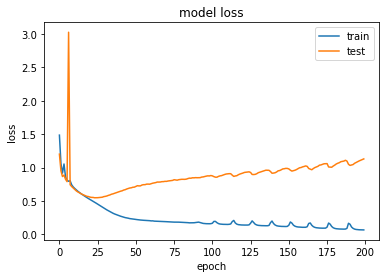

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [16]:
# Save model
model.save("s2s.hdf5")

In [17]:
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("./s2s.hdf5")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [18]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: do you use it as well for your browser ?
Decoded sentence: i love basketball

-
Input sentence: by the way do you like fish ?
Decoded sentence: yes i do

-
Input sentence: did you know that jellyfish are immortal ?
Decoded sentence: yes

-
Input sentence: do you like dance ?
Decoded sentence: i love it

-
Input sentence: did you know babies are really good at dancing ?
Decoded sentence: yes and they smile more when they hit the beat

-
Input sentence: do you like shakespeare ?
Decoded sentence: i love his work

-
Input sentence: say what now ? ? they have that ? ?
Decoded sentence: yeah apparently lol

-
Input sentence: do you like to dance ?
Decoded sentence: i do not

-
Input sentence: how about you ?
Decoded sentence: i agree

-
Input sentence: do you like dance ?
Decoded sentence: i love it

-
Input sentence: did you know bruce lee was a dancer ?
Decoded sentence: yes he even won a cha cha championship in 1958

-
Input sentence: did you know ballet dancers use a l

In [19]:
text = "good morning"
encoded_text = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
for t, char in enumerate(text):
    encoded_text[0, t, input_token_index[char]] = 1.0
    
decoded_sentence = decode_sequence(encoded_text)
print("-")
print("Input sentence:", text)
print("Decoded sentence:", decoded_sentence)

-
Input sentence: good morning
Decoded sentence: i was when i was younger

